In [1]:
!pip install deap
!pip install mealpy
!pip install --upgrade mealpy #upgrade mealpy to the latest version

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from deap import base, creator, tools, algorithms
import tensorflow as tf
import random
import numpy as np
import gc

In [3]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# Veri setini yükleyin
dataset_path = '/content/drive/My Drive/DATASET/final_hate_speech.xlsx'
data = pd.read_excel(dataset_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Prepare data
X = data['tweet']
y = data['etiket']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# TF-IDF transformation
vectorizer = TfidfVectorizer(max_features=2000)  # Adjust as needed
X = vectorizer.fit_transform(X).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Updated model builder function
def build_ann_model(learning_rate, num_hidden_layers, units_per_layer, kernel_size, activation, pooling_index, dropout_rate, optimizer_name):
    pooling_types = [tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D]
    pooling = pooling_types[int(pooling_index)]

    model = Sequential()
    model.add(Dense(units_per_layer, activation=activation, input_shape=(X_train.shape[1],)))
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(units_per_layer, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    optimizer = {
        "SGD": tf.keras.optimizers.SGD(learning_rate=learning_rate),
        "Adam": tf.keras.optimizers.Adam(learning_rate=learning_rate),
        "RMSProp": tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    }[optimizer_name]

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [6]:
# Updated evaluation function
def evaluate_ann_ga(individual):
    learning_rate, batch_size, num_hidden_layers, units_per_layer, kernel_size_index, activation_index, pooling_index, optimizer_index = individual
    activation_functions = ['relu', 'tanh', 'sigmoid']
    optimizers = ['SGD', 'Adam', 'RMSProp']
    kernel_sizes = [(3, 3), (5, 5)]

    activation = activation_functions[int(activation_index)]
    optimizer = optimizers[int(optimizer_index)]
    kernel_size = kernel_sizes[int(kernel_size_index)]

    model = build_ann_model(
        learning_rate=float(learning_rate),
        num_hidden_layers=int(num_hidden_layers),
        units_per_layer=int(units_per_layer),
        kernel_size=kernel_size,
        activation=activation,
        pooling_index=pooling_index,
        dropout_rate=float(0.2),  # Adjust if needed
        optimizer_name=optimizer
    )

    model.fit(X_train, y_train, batch_size=int(batch_size), epochs=3, verbose=0)
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    tf.keras.backend.clear_session()
    gc.collect()
    return accuracy,

In [7]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

toolbox.register("attr_lr", random.uniform, 0.0001, 0.1)
toolbox.register("attr_batch_size", random.choice, [16, 32, 64, 128])
toolbox.register("attr_hidden_layers", random.randint, 1, 5)
toolbox.register("attr_units", random.choice, [8, 16, 32, 64])
toolbox.register("attr_kernel_size", random.randint, 0, 1)
toolbox.register("attr_activation", random.randint, 0, 2)  # Index for ['ReLU', 'tanh', 'sigmoid']
toolbox.register("attr_pooling", random.randint, 0, 1)  # Index for ['MaxPooling', 'AveragePooling']
toolbox.register("attr_optimizer", random.randint, 0, 2)  # Index for ['SGD', 'Adam', 'RMSProp']

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_lr, toolbox.attr_batch_size, toolbox.attr_hidden_layers,
                  toolbox.attr_units, toolbox.attr_kernel_size, toolbox.attr_activation,
                  toolbox.attr_pooling, toolbox.attr_optimizer))


toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_ann_ga)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

In [9]:
import matplotlib.pyplot as plt

# Store results for GA and SA
results = {
    "GA": {"generations": [25, 50], "accuracies": []},
    "SA": {"epochs": [25, 50], "accuracies": []},
}

# Run GA
for num_generations in [25, 50]:
    print(f"Running GA for {num_generations} generations...")
    population = toolbox.population(n=30)  # Reduced population size for memory
    result = algorithms.eaSimple(population, toolbox, cxpb=0.3, mutpb=0.05, ngen=num_generations, verbose=True)
    best_individual = tools.selBest(population, k=1)[0]
    accuracy = evaluate_ann_ga(best_individual)[0]
    print(f"Best Individual (GA, {num_generations} generations):", best_individual)
    print(f"Accuracy (GA, {num_generations} generations): {accuracy}")
    results["GA"]["accuracies"].append(accuracy)

# Run SA
for temp_epochs in [25, 50]:
    print(f"Running SA for {temp_epochs} epochs...")
    best_solution, best_accuracy = sa_optimization()
    print(f"Best Individual (SA, {temp_epochs} epochs):", best_solution)
    print(f"Accuracy (SA, {temp_epochs} epochs): {best_accuracy}")
    results["SA"]["accuracies"].append(best_accuracy)

Running GA for 25 generations...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


gen	nevals
0  	30    
1  	7     
2  	8     
3  	9     
4  	13    
5  	13    
6  	10    
7  	15    
8  	12    
9  	11    
10 	7     
11 	9     
12 	6     
13 	11    
14 	8     
15 	15    
16 	10    
17 	12    
18 	11    
19 	12    
20 	6     
21 	8     
22 	8     
23 	9     
24 	19    
25 	12    
Best Individual (GA, 25 generations): [0.0023198057204426446, 32, 3, 64, 0, 2, 1, 1]
Accuracy (GA, 25 generations): 0.8298288583755493
Running GA for 50 generations...
gen	nevals
0  	30    
1  	12    
2  	14    
3  	14    
4  	7     
5  	10    
6  	5     
7  	9     
8  	15    
9  	8     
10 	8     
11 	5     
12 	10    
13 	14    
14 	16    
15 	6     
16 	13    
17 	5     
18 	8     
19 	13    
20 	6     
21 	10    
22 	9     
23 	3     
24 	9     
25 	20    
26 	10    
27 	13    
28 	14    
29 	8     
30 	9     
31 	13    
32 	9     
33 	17    
34 	18    
35 	13    
36 	15    
37 	6     
38 	7     
39 	10    
40 	10    
41 	10    
42 	10    
43 	10    
44 	14    
45 	10    
46 	12    
47 	10 

ValueError: not enough values to unpack (expected 8, got 7)

In [15]:
def sa_optimization():
    initial_solution = [0.01, 32, 2, 32, 0.2, 1, 0, 2]  # Ensure pooling_index is 0 or 1
    bounds = [
        (0.0001, 0.1),  # learning_rate
        (16, 64),       # batch_size
        (1, 3),         # num_hidden_layers
        (16, 64),       # units_per_layer
        (0.1, 0.3),     # dropout_rate
        (0, 2),         # activation_index
        (0, 1),         # pooling_index (fixed to 0 or 1)
        (0, 2)          # optimizer_index
    ]
    temperature = 100
    cooling_rate = 0.9

    def random_neighbor(solution):
        neighbor = []
        for i, bound in enumerate(bounds):
            if isinstance(bound[0], int):
                neighbor.append(random.randint(bound[0], bound[1]))
            else:
                neighbor.append(random.uniform(bound[0], bound[1]))
        return neighbor

    best_solution = initial_solution
    best_cost = evaluate_ann_ga(best_solution)[0]

    while temperature > 1:
        new_solution = random_neighbor(best_solution)
        new_cost = evaluate_ann_ga(new_solution)[0]

        if new_cost > best_cost or random.uniform(0, 1) < np.exp((new_cost - best_cost) / temperature):
            best_solution = new_solution
            best_cost = new_cost

        temperature *= cooling_rate

    return best_solution, best_cost

In [16]:
# Run SA
for temp_epochs in [25, 50]:
    print(f"Running SA for {temp_epochs} epochs...")
    best_solution, best_accuracy = sa_optimization()
    print(f"Best Individual (SA, {temp_epochs} epochs):", best_solution)
    print(f"Accuracy (SA, {temp_epochs} epochs): {best_accuracy}")
    results["SA"]["accuracies"].append(best_accuracy)

Running SA for 25 epochs...
Best Individual (SA, 25 epochs): [0.0795326462569282, 50, 1, 55, 0.2697997005154085, 1, 0, 2]
Accuracy (SA, 25 epochs): 0.8151589035987854
Running SA for 50 epochs...
Best Individual (SA, 50 epochs): [0.06428373985869346, 32, 2, 20, 0.2746259896892008, 2, 0, 0]
Accuracy (SA, 50 epochs): 0.7466992735862732


In [17]:
# Print Results
print("\nComparison of Results:")
print(f"GA Accuracies: {results['GA']['accuracies']}")
print(f"SA Accuracies: {results['SA']['accuracies']}")


Comparison of Results:
GA Accuracies: [0.8298288583755493, 0.8273838758468628]
SA Accuracies: [0.8151589035987854, 0.7466992735862732]


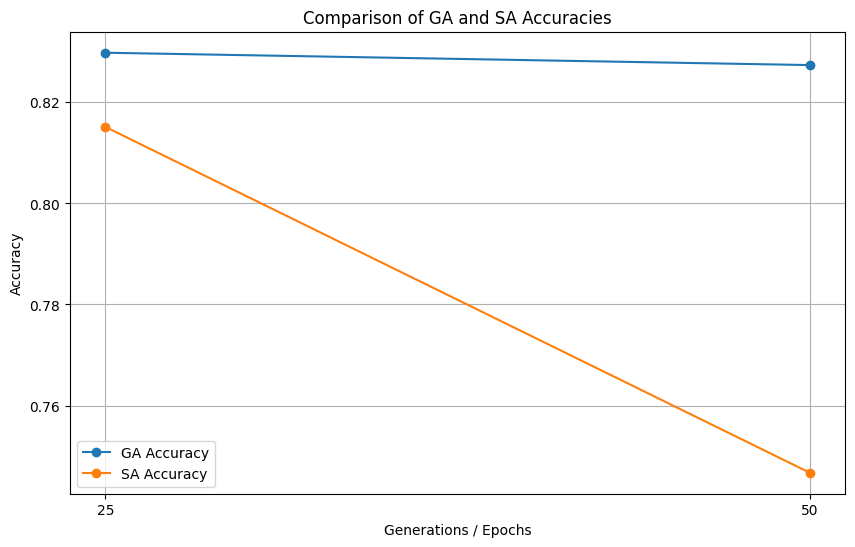

In [18]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(results["GA"]["generations"], results["GA"]["accuracies"], label="GA Accuracy", marker="o")
plt.plot(results["SA"]["epochs"], results["SA"]["accuracies"], label="SA Accuracy", marker="o")

plt.title("Comparison of GA and SA Accuracies")
plt.xlabel("Generations / Epochs")
plt.ylabel("Accuracy")
plt.xticks([25, 50])
plt.legend()
plt.grid(True)
plt.show()